U ovoj bilježnici isprobavamo vgg16 model uz metodu izjednačavanja histograma provedeno na slikama.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn import metrics

In [4]:
train_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/train.csv')
valid_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/validation.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/asub_dataset/preprocessed_newest/test.csv')

train_df

,label,path
0,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1,0,/content/gdrive/MyDrive/asub_dataset/preproces...
2,1,/content/gdrive/MyDrive/asub_dataset/preproces...
3,0,/content/gdrive/MyDrive/asub_dataset/preproces...
4,0,/content/gdrive/MyDrive/asub_dataset/preproces...
...,...,...
1915,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1916,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1917,1,/content/gdrive/MyDrive/asub_dataset/preproces...
1918,1,/content/gdrive/MyDrive/asub_dataset/preproces...


In [5]:
# ucitavanje skupa podataka
X_train = []
y_train = []
for i in range(len(train_df)):
    img = cv.imread(train_df['path'][i])
    img_grayScaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_equ = cv.equalizeHist(img_grayScaled)

    img_final = cv.cvtColor(img_equ, cv.COLOR_GRAY2BGR)

    X_train.append(np.array(img_final))
    y_train.append(train_df['label'][i])


In [6]:
# ucitavanje skupa podataka
X_validation = []
y_validation = []
for i in range(len(valid_df)):
    img = cv.imread(valid_df['path'][i])
    img_grayScaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_equ = cv.equalizeHist(img_grayScaled)
    img_final = cv.cvtColor(img_equ, cv.COLOR_GRAY2BGR)

    X_validation.append(np.array(img_final))
    y_validation.append(valid_df['label'][i])
    

In [7]:
# ucitavanje skupa podataka
X_test = []
y_test = []
for i in range(len(test_df)):
    img = cv.imread(test_df['path'][i])
    img_grayScaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_equ = cv.equalizeHist(img_grayScaled)
    img_final = cv.cvtColor(img_equ, cv.COLOR_GRAY2BGR)

    X_test.append(np.array(img_final))
    y_test.append(test_df['label'][i])
    

In [8]:
# pretvorba u numpy array
X_train = np.array(X_train)
X_validation = np.array(X_validation)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

In [9]:
#provjera dimenzija

print("Shape X_train: {0}".format(X_train.shape))
print("Shape X_validation: {0}".format(X_validation.shape))
print("Shape X_test: {0}".format(X_test.shape))
print("Shape y_train: {0}".format(y_train.shape))
print("Shape y_validation: {0}".format(y_validation.shape))
print("Shape y_test: {0}".format(y_test.shape))

Shape X_train: (1920, 200, 200, 3)
Shape X_validation: (480, 200, 200, 3)
Shape X_test: (600, 200, 200, 3)
Shape y_train: (1920,)
Shape y_validation: (480,)
Shape y_test: (600,)


In [ ]:
#train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=40, width_shift_range=.2, height_shift_range=.2, shear_range=.2, zoom_range=.2, horizontal_flip=True)
#validation_datagen = ImageDataGenerator(rescale=1./255.)
#test_datagen = ImageDataGenerator(rescale=1./255.)

In [10]:
#normalizacija
train_x = tf.keras.utils.normalize(X_train, axis=1)
test_x = tf.keras.utils.normalize(X_test, axis=1)
validation_x = tf.keras.utils.normalize(X_validation, axis=1)

In [11]:
# definiramo callback funkcije koje pomazu kod procesa ucenja
# ReduceLROnPlateau cemo koristiti umjesto da optimiramo hiperparametar stope ucenja
# ako u 2 epohe nismo dobili bolji validation loss, smanjujemo za lr za definirani faktor
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-9,
    verbose=1
)

# ovo je callback koji omogućuje spremanje modela ovisno o accuracyu na validation setu
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal',
    monitor='val_acc',
    save_best_only=True,
    verbose=1
)

In [12]:
## radi se grid search na veličinu batcha
for bs in [16, 32, 64]:
  print('Batch size: {0}\n'.format(bs))

  """
  train_generator = train_datagen.flow(
      X_train, y_train,
      batch_size=batch_size
  )

  validation_generator = validation_datagen.flow(
      X_validation, y_validation,
      batch_size=batch_size
  )
  """

  model_vgg16 = VGG16(
  input_shape=(200, 200, 3),
  include_top=False,
  weights='imagenet'
  )

  for layer in model_vgg16.layers:
      layer.trainable = False

  x = layers.Flatten()(model_vgg16.output)
  x = layers.Dropout(0.25)(x)

  x = layers.Dense(units=256, activation="relu")(x)
  x = layers.Dense(units=1, activation="sigmoid")(x)
  model = tf.keras.Model(model_vgg16.input, x)

  model.compile(
      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics = ['acc']
  )

  ## na kraju treniramo model
  vgg = model.fit(x=train_x, y=y_train, 
                  validation_data=(validation_x, y_validation),
                  batch_size=bs,
                  epochs=40, 
                  verbose=1, 
                  callbacks=[reduce_lr, checkpoint_callback])

Batch size: 16

58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/40
120/120 [==============================] - ETA: 0s - loss: 0.6322 - acc: 0.7255
Epoch 1: val_acc improved from -inf to 0.81042, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal


120/120 [==============================] - 23s 121ms/step - loss: 0.6322 - acc: 0.7255 - val_loss: 0.3818 - val_acc: 0.8104 - lr: 0.0010
Epoch 2/40
120/120 [==============================] - ETA: 0s - loss: 0.3392 - acc: 0.8464
Epoch 2: val_acc improved from 0.81042 to 0.89375, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal


120/120 [==============================] - 13s 110ms/step - loss: 0.3392 - acc: 0.8464 - val_loss: 0.2636 - val_acc: 0.8938 - lr: 0.0010
Epoch 3/40
120/120 [==============================] - ETA: 0s - loss: 0.2717 - acc: 0.8917
Epoch 3: val_acc did not improve from 0.89375
120/120 [==============================] - 10s 84ms/step - loss: 0.2717 - acc: 0.8917 - val_loss: 0.3115 - val_acc: 0.8625 - lr: 0.0010
Epoch 4/40
120/120 [==============================] - ETA: 0s - loss: 0.2241 - acc: 0.9135
Epoch 4: val_acc did not improve from 0.89375
120/120 [==============================] - 10s 84ms/step - loss: 0.2241 - acc: 0.9135 - val_loss: 0.2582 - val_acc: 0.8854 - lr: 0.0010
Epoch 5/40
120/120 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.9198
Epoch 5: val_acc improved from 0.89375 to 0.93125, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal


120/120 [==============================] - 13s 107ms/step - loss: 0.2064 - acc: 0.9198 - val_loss: 0.1809 - val_acc: 0.9312 - lr: 0.0010
Epoch 6/40
120/120 [==============================] - ETA: 0s - loss: 0.1716 - acc: 0.9292
Epoch 6: val_acc improved from 0.93125 to 0.95000, saving model to /content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal


120/120 [==============================] - 13s 110ms/step - loss: 0.1716 - acc: 0.9292 - val_loss: 0.1732 - val_acc: 0.9500 - lr: 0.0010
Epoch 7/40
120/120 [==============================] - ETA: 0s - loss: 0.1317 - acc: 0.9573
Epoch 7: val_acc did not improve from 0.95000
120/120 [==============================] - 11s 90ms/step - loss: 0.1317 - acc: 0.9573 - val_loss: 0.1851 - val_acc: 0.9312 - lr: 0.0010
Epoch 8/40
120/120 [==============================] - ETA: 0s - loss: 0.1246 - acc: 0.9495
Epoch 8: val_acc did not improve from 0.95000
120/120 [==============================] - 11s 91ms/step - loss: 0.1246 - acc: 0.9495 - val_loss: 0.1678 - val_acc: 0.9396 - lr: 0.0010
Epoch 9/40
120/120 [==============================] - ETA: 0s - loss: 0.0945 - acc: 0.9635
Epoch 9: val_acc did not improve from 0.95000
120/120 [==============================] - 11s 91ms/step - loss: 0.0945 - acc: 0.9635 - val_loss: 0.1625 - val_acc: 0.9375 - lr: 0.0010
Epoch 10/40
120/120 [=======================

60/60 [==============================] - 12s 202ms/step - loss: 0.1038 - acc: 0.9656 - val_loss: 0.1634 - val_acc: 0.9521 - lr: 2.0000e-04
Epoch 18/40
60/60 [==============================] - ETA: 0s - loss: 0.0958 - acc: 0.9750
Epoch 18: val_acc did not improve from 0.95208
60/60 [==============================] - 11s 176ms/step - loss: 0.0958 - acc: 0.9750 - val_loss: 0.1579 - val_acc: 0.9521 - lr: 2.0000e-04
Epoch 19/40
60/60 [==============================] - ETA: 0s - loss: 0.0912 - acc: 0.9734
Epoch 19: val_acc did not improve from 0.95208
60/60 [==============================] - 11s 177ms/step - loss: 0.0912 - acc: 0.9734 - val_loss: 0.1783 - val_acc: 0.9375 - lr: 2.0000e-04
Epoch 20/40
60/60 [==============================] - ETA: 0s - loss: 0.0898 - acc: 0.9755
Epoch 20: val_acc did not improve from 0.95208
60/60 [==============================] - 11s 177ms/step - loss: 0.0898 - acc: 0.9755 - val_loss: 0.1571 - val_acc: 0.9417 - lr: 2.0000e-04
Epoch 21/40
60/60 [==============

In [20]:
# predikcije
loaded_model = tf.keras.models.load_model('/content/gdrive/MyDrive/asub_dataset/colab - biljeznice/vgg16-model/best_model - histogram equal')

In [21]:
score = loaded_model.evaluate(test_x, y_test, verbose=1)

19/19 [==============================] - 3s 133ms/step - loss: 0.1463 - acc: 0.9417


In [16]:
output = loaded_model.predict(test_x, verbose=True)
y_predicted = np.where(output > .5, 1, 0)

accuracy = metrics.accuracy_score(y_test, y_predicted)
recall = metrics.recall_score(y_test, y_predicted)
f1 = metrics.f1_score(y_test, y_predicted)

print(f'Accuracy: {accuracy}; Recall: {recall}; F1: {f1}')

19/19 [==============================] - 3s 134ms/step
Accuracy: 0.9416666666666667; Recall: 0.9303135888501742; F1: 0.9384885764499121


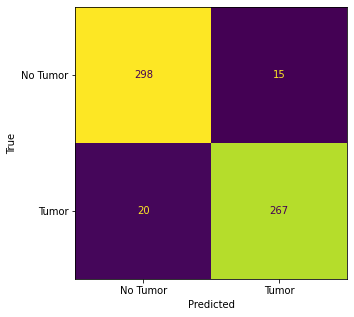

In [17]:
cm = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predicted, colorbar=False, display_labels=['No Tumor', 'Tumor'])
cm.ax_.set(xlabel='Predicted', ylabel='True')
cm.figure_.set_size_inches(5, 5)